## Setting the google colaboratory environment

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
#drive.mount('/content/drive/',  force_remount= True, )
!pip3 install pybind11
import pybind11
%cd /content/drive/'My Drive'/DeepLearningProject/
! bash compile.sh

%tensorflow_version 2.x


#import tensorflow as tf
import tensorflow.compat.v1 as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras import layers 
#import keras
from keras.callbacks import LearningRateScheduler 

planes = 8
moves = 361


#Class Learning Rate optimizer

In [0]:
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import gc
import golois


class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-10, end_lr: float = 1e-1, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)


#The model

In [0]:
input = keras.Input(shape=(19, 19, planes), name='board')

x = layers.Conv2D(256, 5, activation='relu', padding='same')(input)
x = layers.BatchNormalization(axis=1)(x)
x = layers.Dense(16, activation='relu')(x)


y = layers.Conv2D(256, 1, activation='relu', padding='same')(input)
y = layers.BatchNormalization(axis=1)(y)
y = layers.Dense(16, activation='relu')(y)

x = layers.add([x,y])

#tenter

ident = x

########
# block 1
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
#x = layers.AveragePooling2D((2,2))(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu', padding='same')(x) 


x = layers.add([ident,x])
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
#x = layers.AveragePooling2D((3,3))(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.Dense(16, activation='relu')(x)

#ident = layers.AveragePooling2D((4,4))(x)

b = x

#############
# block 2

x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu', padding='same')(x) 
#x = layers.Dense(16, activation='relu')(x)


x = layers.add([b,x])
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.Dense(16, activation='relu')(x)

b = x

#############
# block 3

x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu', padding='same')(x) 
#x = layers.Dense(16, activation='relu')(x)


x = layers.add([b,x])
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.Dense(16, activation='relu')(x)

########
# pooling 

#x = layers.AveragePooling2D((2,2))(x)
z = x

########
# block 4

x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu', padding='same')(x) 
#x = layers.Dense(16, activation='relu')(x)


z = layers.Conv2D(256, 1, activation='relu', padding='same')(z)
z = layers.BatchNormalization(axis=1)(z)
z = layers.Dense(16, activation='relu')(z)

x = layers.add([x,z])

b = x

#############
# block 5

x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu', padding='same')(x) 
#x = layers.Dense(16, activation='relu')(x)


x = layers.add([b,x])
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.Dense(16, activation='relu')(x)

b = x

#############
# block 6

x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu', padding='same')(x) 
#x = layers.Dense(16, activation='relu')(x)


x = layers.add([b,x])
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.Dense(32, activation='relu')(x)

b = x
#############
# block 7

x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x) 
#x = layers.Dense(16, activation='relu')(x)


x = layers.add([b,x])
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.Dense(16, activation='relu')(x)

b = x 
 
policy_head = layers.Conv2D(1, 3, activation='relu', padding='same')(x)
policy_head = layers.BatchNormalization(axis=1)(policy_head)
policy_head = layers.Dense(16, activation='relu')(policy_head) 

value_head = layers.Conv2D(1, 3, activation='relu', padding='same')(x)
value_head = layers.BatchNormalization(axis=1)(value_head)
value_head = layers.Dense(16, activation='relu')(value_head) 



policy_head = layers.add([policy_head,ident])
policy_head = layers.Conv2D(256, 3, activation='relu', padding='same')(policy_head)
policy_head = layers.AveragePooling2D((3,3))(policy_head)
#policy_head = layers.Conv2D(64, 3, activation='relu', padding='same')(policy_head)
policy_head = layers.Dense(16, activation='relu')(policy_head) 

value_head = layers.add([value_head,ident])
value_head = layers.Conv2D(256, 3, activation='relu', padding='same')(value_head)
value_head = layers.AveragePooling2D((3,3))(value_head)
#value_head = layers.Conv2D(128, 3, activation='relu', padding='same')(value_head)
value_head = layers.Dense(8, activation='relu')(value_head)




policy_head = layers.Flatten()(policy_head)
policy_head = layers.Dense(moves, activation='softmax', name='policy')(policy_head)



value_head = layers.Flatten()(value_head)
value_head = layers.Dense(1, activation='sigmoid', name='value')(value_head)

model = keras.Model(inputs=input, outputs=[policy_head, value_head])

model.summary ()
keras.utils.plot_model(model,to_file='goliath_v10.png',show_shapes = True,show_layer_names= True)


model.compile(optimizer=keras.optimizers.SGD(lr=0.1),
            loss={'value': 'mse', 'policy': 'categorical_crossentropy'},
            metrics = ["acc"])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
board (InputLayer)              [(None, 19, 19, 8)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 19, 19, 256)  51456       board[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 19, 19, 256)  2304        board[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 19, 19, 256)  76          conv2d[0][0]                     
______________________________________________________________________________________________

#Training the network

In [0]:
import golois
import gc


model = keras.models.load_model('/content/drive/My Drive/DeepLearningProject/models/goliath_ultimate.h5')

history = np.load('/content/drive/My Drive/DeepLearningProject/history/history_v11-3.npy',allow_pickle='TRUE').item()

#setting the number of epochs
nb_epoch = 200

for i in range(nb_epoch):

    #get_batch
    N = 500000
    input_data = np.random.randint(2, size=(N, 19, 19, planes))
    input_data = input_data.astype ('float32')

    policy = np.random.randint(moves, size=(N,))
    policy = keras.utils.to_categorical (policy)

    value = np.random.randint(2, size=(N,))
    value = value.astype ('float32')

    end = np.random.randint(2, size=(N, 19, 19, 2))
    end = end.astype ('float32')


    golois.getBatch (input_data, policy, value, end)
    #getBatch (input_data, policy, value, end)

    lr_finder = LRFinder()

    _ = model.fit(input_data, {'policy': policy, 'value': value},
          epochs=1, batch_size= 256, validation_split=0.1, callbacks = [lr_finder])



    #lr_finder.plot()

    best = lr_finder.losses.index(min(lr_finder.losses))
    learning_rate = lr_finder.lrs[best]
    print("\nOPTIMIZED LEARNING RATE : " + str(learning_rate))


    call = keras.callbacks.LearningRateScheduler(lambda x : learning_rate, verbose=0)

    history_temp = model.fit(input_data, {'policy': policy, 'value': value},
            epochs=2, batch_size= 256, validation_split=0.1 ,callbacks=[call])

    
    for k,v in history_temp.history.items():
      history[k] += v

    np.save('/content/drive/My Drive/DeepLearningProject/history/history_v11-3.npy', history) 
    model.save ('/content/drive/My Drive/DeepLearningProject/models/goliath_ultimate.h5')


    #free memory
    del input_data, policy, value, end
    gc.collect()

#Plotting the results

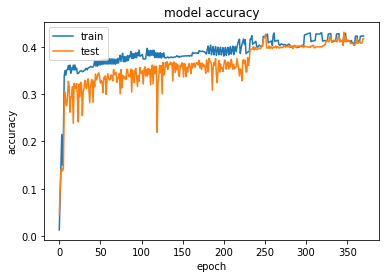

In [0]:
import matplotlib.pyplot as plt

history = np.load('/content/drive/My Drive/DeepLearningProject/history/history_v11-3.npy',allow_pickle='TRUE').item()

plt.plot(history['policy_acc'])
plt.plot(history['val_policy_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

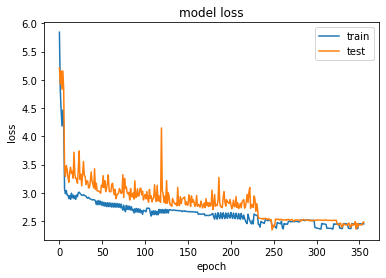

In [0]:

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

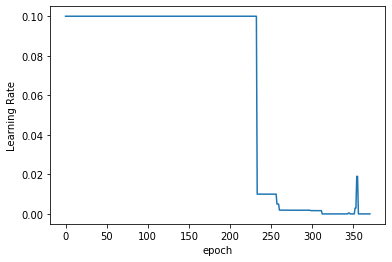

In [0]:
plt.plot(history['lr'])
plt.ylabel('Learning Rate')
plt.xlabel('epoch')
plt.savefig('/content/drive/My Drive/DeepLearningProject/plot/learning_rate.png')
plt.show()